# Handout #3: Instance-based Learning

## Problem 3

**Given datasets** `dsxx34tr.txt` **and** `dsxx34te.txt`, 
find a suitable SVM classifier adopting a *soft-marging* approach. 
You have to define the classifier design strategy, 
including data normalization, e.g. *min-max* scaling,
and setting up the classifier hyper-parameters, 
e.g. by means of *grid-search*, 
as well as estimate the classifier 
performance by means of *n-fold cross validation*.

### Apartat (3.a)

a) Define the design strategy: input data normalization, 
combinations of hyper-parameters considered 
(kernel and its parameters, and $C$), 
number of folds for the cross-validation process.

**NOTE**: typical values for $C$ are 
$10^{−2}$, $10^{−1}$, $10^0$, $10^1$, $10^2$ and $10^3$.

Dades d'identificació:

In [1]:
group = '01' # assuming group 1
ds = 34 # assuming problem 3-4
suffix_tr = 'tr'
suffix_te = 'te'

### Resposta apartat (3.a)

La nostra estratègia per tal de trobar el millor classificador serà 
primerament escalar les dades i després provar alguns kernels 
per a diferents conjunts de paràmetres. 
Per a facilitar la feina, construirem un *pipeline* que serialitzarà 
l'escalat i l'entrenament del classificador. 
Finalment farem una cerca exhaustiva, provant totes 
les possibles combinacions dels paràmetres que hem cregut d'interès 
segons el llegit a la guia d'usuari del classificador *SVC()*

A continuació definirem algunes esctructures y funcions que ens ajudaran a encapsular 
el mètodes que farem servir. 

In [2]:
# Parametritzam algunes propietats de les classes

cl_properties = {
    1: {"target_name": "Classe 1",
        "plot_fmt": "+r",  # red cross
        "hex_color": "#b01010",  # red
        "contrast_fmt": "+w"  # white cross
        },
    -1: {"target_name": "Classe -1", 
        "plot_fmt": "+g",  # green cross
        "hex_color": "#408030",  # green
        "contrast_fmt": "+k"  # black cross
        }
}

cl_properties

{1: {'target_name': 'Classe 1',
  'plot_fmt': '+r',
  'hex_color': '#b01010',
  'contrast_fmt': '+w'},
 -1: {'target_name': 'Classe -1',
  'plot_fmt': '+g',
  'hex_color': '#408030',
  'contrast_fmt': '+k'}}

In [3]:
def get_classes_item_list(item: str) -> list:
    return list(map(lambda k: cl_properties.get(k).get(item), sorted(cl_properties)))

def get_cl_min() -> int:
    return min(cl_properties)

def get_cl_max() -> int:
    return max(cl_properties)

def get_cl_target_name() -> list:
    return get_classes_item_list('target_name')

def get_cl_hex_color() -> list:
    return get_classes_item_list('hex_color')

def get_cl_contrast_fmt() -> list:
    return get_classes_item_list('contrast_fmt')

Importam llibreries

In [4]:
import numpy as np

Carregam dades del problema

In [5]:
# Aquesta funció ens farà més fàcil carregar les matrius

def load_data(group: str, problem: int, sufix: str, 
              convert_zeros: bool = True):
    
    # carregam fitxer del dataset
    data = np.loadtxt('datasets'+group+'/ds'+group+str(ds)+sufix+'.txt')
    # matriu de vectors
    X = data[:, 0:2]
    # vector de classes
    y = data[:, 2:3]
    
    # les classes han de ser -1 i +1
    # per tant si ens ho passen com a 0 i 1 ho transformam
    if convert_zeros and np.any(y == 0):
        y = 2 * y - 1
        
    return X, y

In [6]:
# Carregam 

convert_zeros = (get_cl_min() != 0)

X_train, y_train = load_data(group, ds, suffix_tr, convert_zeros)
y_train = y_train.reshape((-1,))

X_test, y_test = load_data(group, ds, suffix_te, convert_zeros)
y_test = y_test.reshape((-1,))

In [7]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)

(240, 2) (240,)
(60, 2) (60,)


In [8]:
# N és el número de vectors

N = X_train.shape[0]
N

240

Definim algunes funcions que ens ajudaran a dibuixar la constel·lació

In [9]:
def get_cl_index(vector: np.ndarray) -> dict: 
    
    if not isinstance(vector, np.ndarray):
        raise ValueError('El paràmetre vector ha de ser de tipus np.ndarray')
        
    d = dict.fromkeys(cl_properties)
    
    for k in d:
        d[k] = list()
        for index, value in enumerate(vector):
            if value == k: 
                d[k].append(index)
    
    return d

In [10]:
import matplotlib.pyplot as plt

def plot_points(X, y):
    
    cl_index = get_cl_index(y)

    ## començam a dibuixar
    ##
    plt.figure(1)

    ## dibuixam els punts per cada classe
    ##
    for k in cl_properties:
        plt.plot(X[cl_index.get(k), 0], X[cl_index.get(k), 1], 
                 cl_properties.get(k).get('plot_fmt'))

    ## format
    ##
    plt.axis('equal')

    ## etiquetam el que manca i llest
    ##
    plt.title('Punts')
    
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)

    return

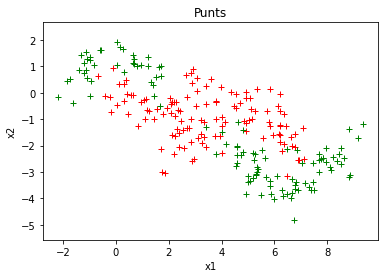

In [11]:
# Vegem quina distribució presenta el conjunt d'entrenament
plot_points(X_train, y_train)

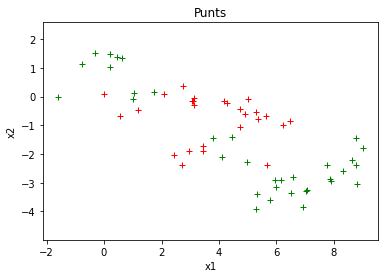

In [12]:
# També representam el conjunt de prova
plot_points(X_test, y_test)

Vaja, sembla que estam davant un **cas de no linealitat**
A més les dades no estan normalitzades.

Per tal de trobar el millor classificador encapsularem dins un *pipe-line* 
els següents processos que detallam:

| Pas | Procés | Eina de `sklearn` |
| :---: | --- | --- |
| 1a | Escalat dels valors de les característiques a un rang \[0,1\] | classe **`MinMaxScaler`** |
| 1b | Escalat dels valors de les característiques a un rang \[0,1\] | classe **`StandardScaler`** |
| 2 | Classificació de les mostres | classe **`SVC`** |

Els passos *1a* i *1b* no s'apliquen de forma simultània, 
és a dir, per a cada entrenament 
sempre se n'aplica un dels dos i només un.

Un cop construït aquest *pipe-line*, el farem servir per a processar còmodament 
les dades del conjunt d'interès.
El processat serà una cerca exhaustiva dels millors (hiper)paràmetres utilitzant 
una instància de la classe **GridSearchCV**, aplicant validació creuada. 
Per tal de construïr els subconjunts de validació farem servir un objecte **StratifiedKFold**, 
que ens garantirà que la distribució de mostres de cada classe a cada grup, és uniforme. 

Tot seguit definirem els diccionaris i variables necessaris per a provar diferents combinacions de paràmetres:

In [13]:
params_clf = []

c_values_to_try = [10**ex for ex in range(-2, 5 + 1)]

In [14]:
# kernel lineal: per tal de donar a la resposta un caire de completitud, 
#   afegim també el kernel lineal, tot i que sabem que per la nostra distribució 
#   donaria una mala classificació

params_clf.append(
    {
        'clf__kernel': ['linear'],
        'clf__C': c_values_to_try
    }
)

In [15]:
#kernel polynomial: provarem el kernel polinòmic homogeni (x.T z)^q 
#   i també el no homogeni (g x.T z + r)^q

params_clf.append(
    {
        'clf__kernel': ['poly'], 
        'clf__C': c_values_to_try,
        'clf__gamma': ['scale', 0.5, 1, 2],  # g
        'clf__coef0': [-1, 0, 1],   # r
        'clf__degree': [1, 2, 3]    # q
    }
)

In [16]:
#kernel RBF: 

params_clf.append(
    {
        'clf__kernel': ['rbf'], 
        'clf__C': c_values_to_try,
        'clf__gamma': ['scale', 0.5, 1, 2, 4, 8]
    }
)

In [17]:
#kernel sigmoid: tanh(g x.T z + r)

params_clf.append(
    {
        'clf__kernel': ['sigmoid'], 
        'clf__C': c_values_to_try,
        'clf__gamma': ['scale', 0.5, 1, 2],
        'clf__coef0': [-1, 0, 1]
    }
)

Ara també cal fer dos itineraris, 
ignorant els objectes d'escalat de forma alternativa:

In [18]:
def dict_with_new_entries(old_dict: dict, new_entries: dict) -> dict:
    new_dict = old_dict.copy()
    for entry in new_entries:
        new_dict[entry] = new_entries.get(entry)
        
    return new_dict

def add_scaler_passthrough(params_dict) -> list:
    params_list_dict = []
    for clf_param in params_dict:
        new_dict = dict_with_new_entries(clf_param, 
                                         {'scaler_std': ['passthrough']}) 
        params_list_dict.append(new_dict)

        new_dict = dict_with_new_entries(clf_param,
                                         {'scaler_mm': ['passthrough']}) 
        params_list_dict.append(new_dict)
        
    return params_list_dict

In [19]:
params_to_try = add_scaler_passthrough(params_clf)
params_to_try

[{'clf__kernel': ['linear'],
  'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
  'scaler_std': ['passthrough']},
 {'clf__kernel': ['linear'],
  'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
  'scaler_mm': ['passthrough']},
 {'clf__kernel': ['poly'],
  'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
  'clf__gamma': ['scale', 0.5, 1, 2],
  'clf__coef0': [-1, 0, 1],
  'clf__degree': [1, 2, 3],
  'scaler_std': ['passthrough']},
 {'clf__kernel': ['poly'],
  'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
  'clf__gamma': ['scale', 0.5, 1, 2],
  'clf__coef0': [-1, 0, 1],
  'clf__degree': [1, 2, 3],
  'scaler_mm': ['passthrough']},
 {'clf__kernel': ['rbf'],
  'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
  'clf__gamma': ['scale', 0.5, 1, 2, 4, 8],
  'scaler_std': ['passthrough']},
 {'clf__kernel': ['rbf'],
  'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
  'clf__gamma': ['scale', 0.5, 1, 2, 4, 8],
  'scaler_mm': ['passthrough']},
 {'clf__ker

In [20]:
# Validation using k-fold validation

# normalment faríem servir k = 5, però com que tenim pocs punts (240), només farem tres grups

n_folds = 3

Importam les classes i funcions necessàries:

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [22]:
# ... employing the accuracy as performance metric ...

score = 'accuracy'

Començam la **construcció del *pipeline***, 
que ens determinarà quin és el millor 
conjunt de paràmetres del classificador *SVC*, 
de entre tots els que provarem 
a banda de determinar quin dels dos mètodes d'escalat és el millor 
pel nostre cas.

In [23]:
# Primera passa: escalat del valors de les característiques de les mostres

# Provarem dos mètodes d'escalat per a cada conjunt de paràmetres

scaler_mm = MinMaxScaler()

scaler_mm_step = ('scaler_mm', scaler_mm)

scaler_std = StandardScaler()

scaler_std_step = ('scaler_std', scaler_std)

In [24]:
# Segona passa: classificar les mostres

# En aquest exercici, pel classificador que ens demanen, s'ha de fer servir la classe SVC com a model

from sklearn.svm import SVC

clf_step = ('clf', SVC())

In [25]:
# Construïm la tuberia

pipe_steps = [scaler_std_step, scaler_mm_step, clf_step]

gs_clf_p = Pipeline(pipe_steps)

In [26]:
from sklearn import set_config

set_config(display='diagram')
display(gs_clf_p)
set_config(display='text')

Pipeline(steps=[('scaler_std', StandardScaler()), ('scaler_mm', MinMaxScaler()),
                ('clf', SVC())])

### Apartat (3.b)

b) Using the *training dataset*, 
find the best performing classifier according to 
the design strategy and employing the accuracy as 
performance metric for the cross-validation process.

### Resposta apartat(3.b)

Un cop construït el *pipeline*, ja el podem fer servir per fer la cerca dels (hiper)paràmetres

In [27]:
# Segona passa: fer la cerca exhaustiva dels millors (hiper)paràmetres

# Construirem els subconjunts de validació de forma equilibrada 
# (és a dir amb un percentatge de mostres de cada classe similar)

stra_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=11615)

n_jobs = -1  # Utilitzam tots els fils d'execució
verbose_level = 1  # Ens ajudarà a passar una estona més entretinguda ...

gs_cv = GridSearchCV(estimator=gs_clf_p,
                    cv=stra_kfold,
                    param_grid=params_to_try,
                    scoring=score,
                    n_jobs=n_jobs,
                    verbose=verbose_level)

In [28]:
# Començam les proves ...

gs_cv.fit(X_train, y_train)

Fitting 3 folds for each of 880 candidates, totalling 2640 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11615, shuffle=True),
             estimator=Pipeline(steps=[('scaler_std', StandardScaler()),
                                       ('scaler_mm', MinMaxScaler()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000,
                                     100000],
                          'clf__kernel': ['linear'],
                          'scaler_std': ['passthrough']},
                         {'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000,
                                     100000...
                          'scaler_mm': ['passthrough']},
                         {'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000,
                                     100000],
                          'clf__coef0': [-1, 0, 1],
                          'clf__gamma': ['scale', 0.5, 1, 2],
                          'clf__kernel': ['sigmoid'],
   

In [29]:
# Triam el millor segons la mètrica que li hem donat (accuracy)

best_clf = gs_cv.best_estimator_

La **millor arquitectura** del *pipeline* és:

In [30]:
set_config(display='diagram')
display(best_clf)
set_config(display='text')

Pipeline(steps=[('scaler_std', 'passthrough'), ('scaler_mm', MinMaxScaler()),
                ('clf', SVC(C=10000, gamma=4))])

In [31]:
def get_best_params():
    
    return gs_cv.best_params_

Aquests són els **millors paràmetres del *pipeline***

In [32]:
best_params = get_best_params()
best_params

{'clf__C': 10000,
 'clf__gamma': 4,
 'clf__kernel': 'rbf',
 'scaler_std': 'passthrough'}

És a dir, hem trobat que és millor 
**escalar les mostres amb *MinMaxScaler()***

In [33]:
# Vegem quina és la mètrica 'accuracy' del millor classificador

best_accuracy = gs_cv.best_score_

Hem aconseguit un **promig de *accuracy* durant l'entrenament** 
amb *cross-validation* de:

In [34]:
f"{best_accuracy:.3f}"

'0.929'

In [35]:
def get_best_step_params(from_dict: dict, step: str) -> dict:
    
    prefix_len = len(step)
    
    if prefix_len > 0:
        new_dict = dict()
        for key in from_dict:
            if str(key).startswith(step): 
                new_key = key[prefix_len:]
                if len(new_key) > 0:
                    new_dict[new_key] = from_dict[key]
    else:
        new_dict = from_dict

    return new_dict

In [36]:
# I aquests són els que només afecten al classificador

clf_best_params = get_best_step_params(best_params, 'clf__')

Per tant, el **millor classificador** 
que hem trobat és el que podem construir 
amb aquests paràmetres ...

In [37]:
clf_best_params

{'C': 10000, 'gamma': 4, 'kernel': 'rbf'}

... escalant prèviament les mostres amb MinMaxScaler()

In [38]:
def rbf_func(x): 
    
    return best_clf.decision_function([x]).item()

def get_sv() -> list:
    
    return best_clf.named_steps['clf'].support_

### Apartat (3.c)

c) Generate the following plots **in the original space**:
1. a first plot with *the training samples*, highlighting the *support vectors* and plotting the 2D *decision curve*; and
2. a second plot with the *classification map*, i.e. evaluate the *decision function* for a 'regular' subset (grid) of points.

Use different markers and/or colours for each class. 
See the appendix for examples of the requested plots.

### Resposta apartat (3.c)

Definim algunes funcions necessàries per a fer els diagrames.

In [39]:
import numpy as np

def get_view_limits(X: np.ndarray, extra_border: float = 0.):
    
    ### límits del diagrama:
    x_left = np.floor(np.amin(X, axis = 0)[0] - 0.5 - extra_border)
    x_right = np.ceil(np.amax(X, axis = 0)[0] + 0.5 + extra_border)
    y_top = np.ceil(np.amax(X, axis = 0)[1] + 0.5 + extra_border)
    y_bottom = np.floor(np.amin(X, axis = 0)[1]- 0.5 - extra_border)
    
    return x_left, x_right, y_bottom, y_top


def get_mesh(g_func, 
             x_left: float, x_right: float, y_bottom: float, y_top: float, 
             res: int = 100):

    # calcula malla
    
    xx = np.linspace(x_left, x_right, res)
    yy = np.linspace(y_bottom, y_top, res)
    XX, YY = np.meshgrid(xx, yy, indexing = 'ij')
    Z = np.zeros((res * res, 1))

    k = 0
    for x1 in xx:
        for x2 in yy:
            Z[k] = g_func(np.array((x1, x2), dtype=float))
            k += 1

    return XX, YY, Z

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scatter_contour(X: np.ndarray, y: np.ndarray, sv: list, 
                         g_func, margin_level: float=1., 
                         extra_border: float=0.):
    
    # plot samples, highlighting some of them

    ## calcula límits cartesians a representar
    ##
    x_left, x_right, y_bottom, y_top = get_view_limits(X, extra_border)
    
    ## calcula malla de valors de la funció
    ##
    XX, YY, Z = get_mesh(g_func, x_left, x_right, y_bottom, y_top)
    
    ## calcula index de cada classe
    cl_index = get_cl_index(y)

    ## començam a dibuixar
    ##
    plt.figure(1, figsize = (8,8))


    ## dibuixam la corba de decisió i els marges
    ##
    ax = plt.gca()
    ax.contour(XX, YY, Z.reshape(XX.shape), 
               colors='k',
               levels=[-margin_level, 0, margin_level],
               alpha=0.5,linestyles=['--', '-', '--'])

    ## dibuixam els punts per cada classe
    ##
    for k in cl_properties:
        plt.plot(X[cl_index.get(k), 0], X[cl_index.get(k), 1], 
                 cl_properties.get(k).get('plot_fmt'))

    ## i remarcam els vectors de suport
    ##
    ax2 = plt.gca()
    ax2.scatter(X[sv, 0], X[sv, 1], s = 100, 
               linewidth = 1, facecolors = 'none', edgecolors = 'k')

    ## format
    ##
    plt.xlim([x_left, x_right])
    plt.ylim([y_bottom, y_top])
    plt.axis('equal')

    ## etiquetam el que manca i llest
    ##
    plt.title('Punts, vectors de suport i corba de decisió amb marges')
    
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)
    
    return

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

def plot_map_plane(X: np.ndarray, y: np.ndarray, sv: list, 
                   g_func, 
                   extra_border: float=0.,
                   plot_3d: bool=True): 
    
    # matrix-based predicate evaluation

    ## calcula límits cartesians a representar
    ##
    x_left, x_right, y_bottom, y_top = get_view_limits(X, extra_border)
    
    ## calcula malla de valors de la funció
    ##
    XX, YY, Z = get_mesh(g_func, x_left, x_right, y_bottom, y_top)
    
    ## calcula index de cada classe
    cl_index = get_cl_index(y)
    
    ## i valors de la classe
    cl_min = get_cl_min()
    cl_max = get_cl_max()

    ## començam a dibuixar
    ##
    plt.figure(1, figsize=(8,8))

    ## cream paleta de colors
    ##
    paleta = col.LinearSegmentedColormap.from_list(
        'SVM_color', get_cl_hex_color())

    ## reduïm a només dues classes
    ##
    C = np.where(Z >= 0, cl_max, cl_min)

    ## cream mapa i llegenda
    ##
    plt.imshow(
        C.reshape(XX.shape).T, 
        origin = 'lower', 
        extent = (x_left, x_right, y_bottom, y_top), 
        cmap = paleta)
    plt.colorbar()
    
    ## dibuixam els punts per cada classe
    ##
    for k in cl_properties:
        plt.plot(X[cl_index.get(k), 0], X[cl_index.get(k), 1], 
                 cl_properties.get(k).get('contrast_fmt'))

    ## format
    ##
    plt.title("Mapa de l'avaluació de la funció de classificació")
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.axis('equal')
    
    ## mostram
    ##
    plt.show(block=False) # to force visualization

    if plot_3d:
        ## també dibuixarem el plànol en 3D
        ##
        plt.figure(2, figsize=(8,8))
        ax = plt.axes(projection='3d')

        ax.plot_surface(XX, YY, Z.reshape(XX.shape), 
                        rstride = 1, cstride = 1, 
                        vmin = cl_min, vmax = cl_max,
                        cmap = paleta, 
                        edgecolor = 'none')

        ## ajustam l'àngle per veure'l millor
        ##
        ax.view_init(30, -60)

        ## etiquetam el que manca i llest
        ##
        plt.title('Superfície classificadora')

        plt.xlabel('x1')
        plt.ylabel('x2')

        plt.show(block = False)
    
    return

#### Resultat punt (3.c.1)

La representació a l'**espai original** de les *mostres d'entrenament*, els *vectors de suport*
i les *corbes de decisió*, són:

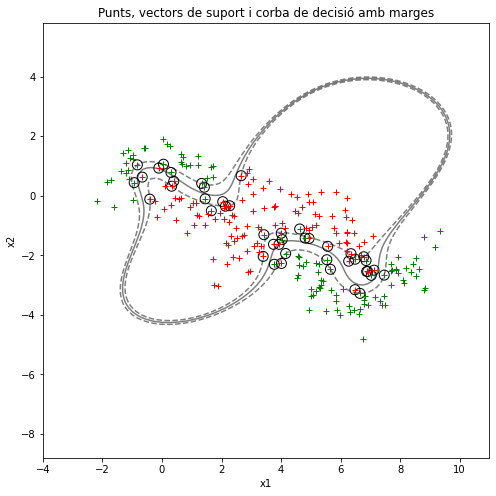

In [42]:
sv=get_sv()

plot_scatter_contour(X_train, y_train, sv, rbf_func, extra_border=1.)

#### Resultat punt (3.c.2)

La representació a l'espai original del *mapa de classificació*, és:

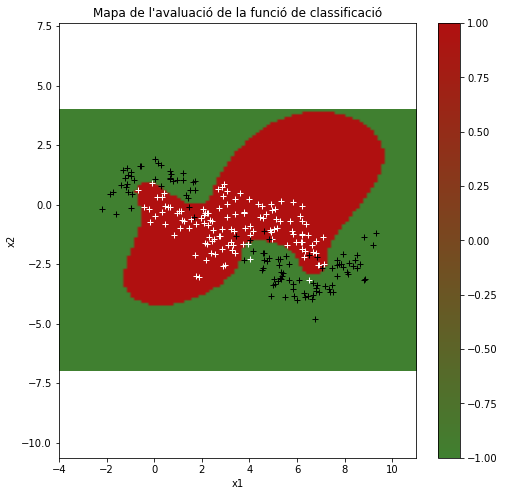

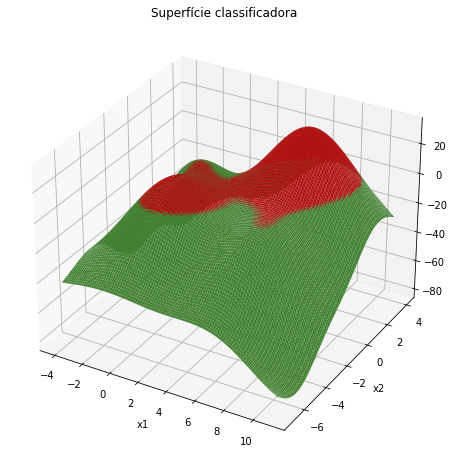

In [43]:
plot_map_plane(X_train, y_train, sv, rbf_func, extra_border=1.)

### Apartat (3.d)

d) Report on the classifier performance using the *test dataset*:
1. measure the *test accuracy*, *test precision*, *test recall* and *test f1-score*; and
2. in a single figure, plot the *test samples* over the already calculated *classification map* (use different markers and/or colours for each class).

### Resposta apartat (3.d)

Ara que ja sabem quin és el millor binomi escalador/classificador, 
provarem a classificar el conjunt de prova:

In [44]:
y_pred = best_clf.predict(X_test)

Vegem un resum de les mètriques de la classificació del conjunt de prova:

In [45]:
print(classification_report(y_true=y_test, 
                            y_pred=y_pred, 
                            target_names=get_cl_target_name()))

              precision    recall  f1-score   support

   Classe -1       0.94      0.85      0.89        34
    Classe 1       0.83      0.92      0.87        26

    accuracy                           0.88        60
   macro avg       0.88      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60



Pel que sembla la *accuracy* ha baixat.

Vegem que diu la matriu de confusió: 

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, )
cm

array([[29,  5],
       [ 2, 24]])

| | predites com a pertanyents a classe $y=-1$ | predites com a pertanyents a classe $y=+1$ |
| --- | :---: | :---: |
| mostres que realment pertanyen a la classe $y=-1$ | 29 |  5 |
| mostres que realment pertanyen a la classe $y=+1$ |  2 | 24 |

Que, en efecte, ens torna a acreditar que la *accuracy* al conjunt de prova ha baixat:

$$\text{accuracy} = \frac{\text{mostres predites correctament}}{\text{total de mostres}} = \frac{29+24}{29+5+2+24} = 0.883$$

Hem obtingut una *accuracy* al conjunt de prova del 0.883, 
en front als 0.929 obtinguts al llarg de l'entrenament.

Per tant sembla que el classificador 
pateix d'una **manca de capacitat de generalització**. 

#### Resposta punt (3.d.1)

Les mesures que ens demanen són aquestes:

In [47]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Test accuracy : {test_accuracy:.3f}")
print(f"Test precision: {test_precision:.3f}")
print(f"Test recall   : {test_recall:.3f}")
print(f"Test f1       : {test_f1:.3f}")

Test accuracy : 0.883
Test precision: 0.828
Test recall   : 0.923
Test f1       : 0.873


#### Resposta punt (3.d.2)

Aquest és el diagrama que representa la distribució de les mostres
del conjunt de prova dins el mapa de classificació:

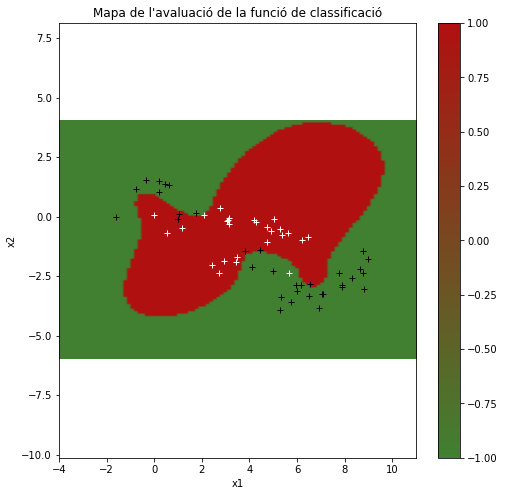

In [48]:
plot_map_plane(X_test, y_test, [], rbf_func, extra_border=1., plot_3d=False)

### Apartat (3.e)

e) Obtain an improved estimation of the *accuracy*, *precision* and *recall* measures by means of *5-fold cross-validation*. To this end, put together the *training* and *test* datasets, so that the corresponding function can
build the *folds* from all available data.

In [49]:
X = np.concatenate((X_train, X_test), axis=0)
X.shape

(300, 2)

In [50]:
y = np.concatenate((y_train, y_test), axis=0)
y.shape

(300,)

In [51]:
clf_best_params

{'C': 10000, 'gamma': 4, 'kernel': 'rbf'}

In [52]:
clf = SVC()
clf.set_params(**clf_best_params)

SVC(C=10000, gamma=4)

In [53]:
clfp = make_pipeline(MinMaxScaler(), clf)
display(clfp)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=10000, gamma=4))])

In [54]:
scoring = ['accuracy']
scores = cross_validate(clfp, X, y, cv=5, scoring=scoring)

In [55]:
print('accuracy: ', scores['test_accuracy'])
print(f"avg acc.: {np.mean(scores['test_accuracy']):.3f}")

accuracy:  [0.88333333 0.96666667 0.91666667 0.93333333 0.88333333]
avg acc.: 0.917


La *accuracy* obtinguda amb el conjunt ampliat de mostres
és semblant, encara que un punt inferior a la del conjunt inicial, 
un 91,7% en front al 92,9% de l'entrenament original.

---

## Problem 4

**Given datasets** `dsxx34tr.txt` **and** `dsxx34te.txt`, 
find a suitable k-NN classifier 
(`KNeighborsClassifier` object of `scikit-learn`).
You have to define the classifier design strategy, 
including data normalization, e.g. *min-max* scaling,
and setting up the classifier hyper-parameters, 
e.g. by means of *grid-search*, 
as well as estimate the classifier 
performance by means of *n-fold cross validation*.

### Apartat (4.a)

a) Define the design strategy: input data normalization, 
combinations of hyper-parameters considered 
(number of neighbours and distance function), 
number of folds for the cross-validation process.

### Resposta apartat (4.a)

Definirem la llista de paràmetres a provar.

In [56]:
knn_params_clf = []

In [57]:
# provarem diverses combinacions

knn_params_clf.append(
    {
        'clf__n_neighbors': [1, 3, 5, 7],
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2, 3], 
        'clf__metric': ['minkowski']
    }
)

In [58]:
# Chbyshev: max|x - z|

knn_params_clf.append(
    {
        'clf__n_neighbors': [1, 3, 5, 7],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['chebyshev']
    }
)

Ara també cal fer dos itineraris, 
ignorant els objectes d'escalat de forma alternativa:

In [59]:
knn_params_to_try = add_scaler_passthrough(knn_params_clf)
knn_params_to_try

[{'clf__n_neighbors': [1, 3, 5, 7],
  'clf__weights': ['uniform', 'distance'],
  'clf__p': [1, 2, 3],
  'clf__metric': ['minkowski'],
  'scaler_std': ['passthrough']},
 {'clf__n_neighbors': [1, 3, 5, 7],
  'clf__weights': ['uniform', 'distance'],
  'clf__p': [1, 2, 3],
  'clf__metric': ['minkowski'],
  'scaler_mm': ['passthrough']},
 {'clf__n_neighbors': [1, 3, 5, 7],
  'clf__weights': ['uniform', 'distance'],
  'clf__metric': ['chebyshev'],
  'scaler_std': ['passthrough']},
 {'clf__n_neighbors': [1, 3, 5, 7],
  'clf__weights': ['uniform', 'distance'],
  'clf__metric': ['chebyshev'],
  'scaler_mm': ['passthrough']}]

In [60]:
# Validation using k-fold validation

# normalment faríem servir k = 5, però com que tenim pocs punts (240), només farem tres grups

knn_n_folds = 3

Importam les classes i funcions necessàries:

In [61]:
from sklearn.neighbors import KNeighborsClassifier

In [62]:
# ... employing the accuracy as performance metric ...

knn_score = 'accuracy'

Començam la **construcció del *pipeline***, 
que ens determinarà quin és el millor 
conjunt de paràmetres del classificador *KNN*, 
de entre tots els que provarem 
a banda de determinar quin dels dos mètodes d'escalat és el millor 
pel nostre cas.

In [63]:
# Primera passa: escalat del valors de les característiques de les mostres

# Provarem dos mètodes d'escalat per a cada conjunt de paràmetres

knn_scaler_mm = MinMaxScaler()

knn_scaler_mm_step = ('scaler_mm', knn_scaler_mm)

knn_scaler_std = StandardScaler()

knn_scaler_std_step = ('scaler_std', knn_scaler_std)

In [64]:
# Segona passa: classificar les mostres

# En aquest exercici, pel classificador que ens demanen, 
# s'ha de fer servir la classe KNeighborsClassifier com a model

knn_gs_clf_step = ('clf', KNeighborsClassifier())

In [65]:
# Construïm la tuberia

knn_pipe_steps = [knn_scaler_std_step, knn_scaler_mm_step, knn_gs_clf_step]

knn_gs_clf_p = Pipeline(knn_pipe_steps)

In [66]:
set_config(display='diagram')
display(knn_gs_clf_p)
set_config(display='text')

Pipeline(steps=[('scaler_std', StandardScaler()), ('scaler_mm', MinMaxScaler()),
                ('clf', KNeighborsClassifier())])

### Apartat (4.b)

b) Using the *training dataset*, find the best performing classifier according to the design strategy and employing the accuracy as performance metric for the cross-validation process.

### Resposta apartat(4.b)

Un cop construït el *pipeline*, ja el podem fer servir per fer la cerca dels (hiper)paràmetres

In [67]:
# Segona passa: fer la cerca exhaustiva dels millors (hiper)paràmetres

# Construirem els subconjunts de validació de forma equilibrada 
# (és a dir amb un percentatge de mostres de cada classe similar)

knn_stra_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, 
                                 random_state=11615)

n_jobs = -1  # Utilitzam tots els fils d'execució
verbose_level = 1  # Ens ajudarà a passar una estona més entretinguda ...

knn_gs_cv = GridSearchCV(estimator=knn_gs_clf_p,
                        cv=knn_stra_kfold,
                        param_grid=knn_params_to_try,
                        scoring=knn_score,
                        n_jobs=n_jobs,
                        verbose=verbose_level)

In [68]:
# Començam les proves ...

knn_gs_cv.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11615, shuffle=True),
             estimator=Pipeline(steps=[('scaler_std', StandardScaler()),
                                       ('scaler_mm', MinMaxScaler()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'clf__metric': ['minkowski'],
                          'clf__n_neighbors': [1, 3, 5, 7], 'clf__p': [1, 2, 3],
                          'clf__weights': ['uniform', 'distance'],
                          'scaler_std': ['pass...
                          'clf__n_neighbors': [1, 3, 5, 7], 'clf__p': [1, 2, 3],
                          'clf__weights': ['uniform', 'distance'],
                          'scaler_mm': ['passthrough']},
                         {'clf__metric': ['chebyshev'],
                          'clf__n_neighbors': [1, 3, 5, 7],
                          'clf__weights': ['uniform', 'distance'],
                          'scaler_std'

In [69]:
# Triam el millor segons la mètrica que li hem donat (accuracy)

knn_best_clf = knn_gs_cv.best_estimator_

La **millor arquitectura** del *pipeline* és:

In [70]:
set_config(display='diagram')
display(knn_best_clf)
set_config(display='text')

Pipeline(steps=[('scaler_std', 'passthrough'), ('scaler_mm', MinMaxScaler()),
                ('clf', KNeighborsClassifier(p=3, weights='distance'))])

In [71]:
def get_knn_best_params():
    
    return knn_gs_cv.best_params_

Aquests són els **millors paràmetres del *pipeline***

In [72]:
get_knn_best_params()

{'clf__metric': 'minkowski',
 'clf__n_neighbors': 5,
 'clf__p': 3,
 'clf__weights': 'distance',
 'scaler_std': 'passthrough'}

Observam que és millor 
**escalar les mostres amb *MinMaxScaler()***

In [73]:
# Vegem quina és la mètrica 'accuracy' del millor classificador

knn_best_accuracy = knn_gs_cv.best_score_

Hem aconseguit un **promig de *accuracy* durant l'entrenament** 
amb *cross-validation* de:

In [74]:
f"{knn_best_accuracy:.3f}"

'0.933'

In [75]:
# I aquests són els que només afecten al classificador

knn_best_params = get_knn_best_params()

knn_clf_best_params = get_best_step_params(knn_best_params, 'clf__')

Per tant, el **millor classificador** 
que hem trobat és el que podem construir 
amb aquests paràmetres ...

In [76]:
knn_clf_best_params

{'metric': 'minkowski', 'n_neighbors': 5, 'p': 3, 'weights': 'distance'}

... escalant prèviament les mostres amb MinMaxScaler()

### Apartat (4.c)

c) Plot the training samples on top of the *classification map*, i.e. evaluate the decision function for a 'regular' subset (grid) of points of the feature space. 
Use different markers and/or colours for each class.

### Resposta apartat (4.c)

La representació del mapa de classificació, 
juntament amb el conjunt de mostres és:

In [77]:
def knn_func(x): 
    
    return knn_best_clf.predict([x]).item()

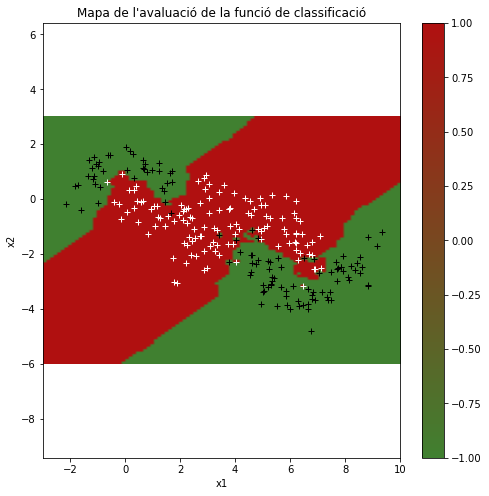

In [78]:
plot_map_plane(X_train, y_train, [], knn_func, plot_3d=False)

### Apartat (4.d)

d) Report on the classifier performance using the *test dataset*:
1. measure the *test accuracy*, *test precision*, *test recall* and *test f1-score*; and
2. in a single figure, plot the *test samples* over the already calculated *classification map* (use different markers and/or colours for each class).

### Resposta apartat (4.d)

Ara que ja sabem quin és el millor binomi escalador/classificador, 
provarem a classificar el conjunt de prova:

In [79]:
knn_y_pred = knn_best_clf.predict(X_test)

Vegem un resum de les mètriques de la classificació del conjunt de prova:

In [80]:
print(classification_report(y_true=y_test, 
                            y_pred=knn_y_pred, 
                            target_names=get_cl_target_name()))

              precision    recall  f1-score   support

   Classe -1       0.97      0.91      0.94        34
    Classe 1       0.89      0.96      0.93        26

    accuracy                           0.93        60
   macro avg       0.93      0.94      0.93        60
weighted avg       0.94      0.93      0.93        60



Vegem que diu la matriu de confusió: 

In [81]:
from sklearn.metrics import confusion_matrix

knn_cm = confusion_matrix(y_test, knn_y_pred, )
knn_cm

array([[31,  3],
       [ 1, 25]])

| | predites com a pertanyents a classe $y=-1$ | predites com a pertanyents a classe $y=+1$ |
| --- | :---: | :---: |
| mostres que realment pertanyen a la classe $y=-1$ | 31 |  3 |
| mostres que realment pertanyen a la classe $y=+1$ |  1 | 25 |

Que, en efecte, ens torna a acreditar que la *accuracy* al conjunt de prova ha baixat:

$$\text{accuracy} = \frac{\text{mostres predites correctament}}{\text{total de mostres}} = \frac{31+25}{31+3+1+25} = 0.933$$

Hem obtingut una *accuracy* al conjunt de prova del 0.933, 
en front als 0.929 obtinguts al llarg de l'entrenament.

Per tant sembla que el classificador resultant 
**generalitza molt bé**. 

#### Resposta punt (4.d.1)

Les mesures que ens demanen són aquestes:

In [82]:
knn_test_accuracy = accuracy_score(y_test, knn_y_pred)
knn_test_precision = precision_score(y_test, knn_y_pred)
knn_test_recall = recall_score(y_test, knn_y_pred)
knn_test_f1 = f1_score(y_test, knn_y_pred)

print(f"Test accuracy : {knn_test_accuracy:.3f}")
print(f"Test precision: {knn_test_precision:.3f}")
print(f"Test recall   : {knn_test_recall:.3f}")
print(f"Test f1       : {knn_test_f1:.3f}")

Test accuracy : 0.933
Test precision: 0.893
Test recall   : 0.962
Test f1       : 0.926


#### Resposta punt (4.d.2)

Aquest és el diagrama que representa la distribució de les mostres
del conjunt de prova dins el mapa de classificació:

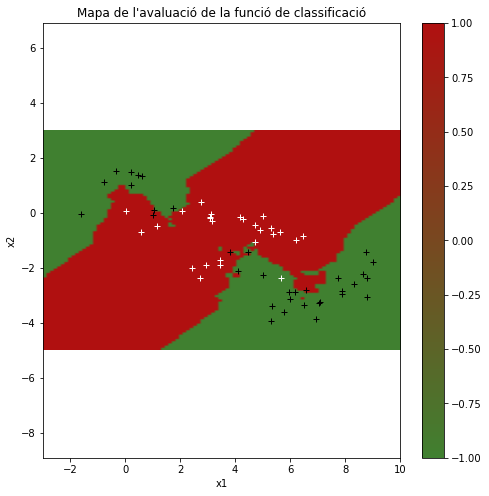

In [83]:
plot_map_plane(X_test, y_test, [], knn_func, plot_3d=False)

### Apartat (4.e)

e) Obtain an improved estimation of the *accuracy*, *precision* and *recall* measures by means of *5-fold cross-validation*. To this end, put together the *training* and *test* datasets, so that the corresponding function can
build the *folds* from all available data.

### Resposta apartat (4.e)

In [84]:
knn_clf_best_params

{'metric': 'minkowski', 'n_neighbors': 5, 'p': 3, 'weights': 'distance'}

In [85]:
knn_clf = KNeighborsClassifier()
knn_clf.set_params(**knn_clf_best_params)

KNeighborsClassifier(p=3, weights='distance')

In [86]:
knn_clfp = make_pipeline(MinMaxScaler(), knn_clf)
display(knn_clfp)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(p=3, weights='distance'))])

In [87]:
knn_scoring = ['accuracy']
knn_scores = cross_validate(knn_clfp, X, y, cv=5, scoring=knn_scoring)

In [88]:
print('accuracy: ', knn_scores['test_accuracy'])
print(f"avg acc.: {np.mean(knn_scores['test_accuracy']):.3f}")

accuracy:  [0.9        0.95       0.91666667 0.91666667 0.93333333]
avg acc.: 0.923


La *accuracy* obtinguda amb el conjunt ampliat de mostres
és molt semblant a la del conjunt inicial, 
un 92,3% en front al 92,9% de l'entrenament original.

---

## Conclusions

En aquests dos problemes hem obtingut dos classificadors
amb distints principis de classificació
per a un mateix conjunt de dades.
El primer, basat el vectors de suport i el segon 
en el càlcul de les distàncies als veïns més propers.

Per tal d'obtenir les dues millors instàncies de classificació 
hem aplicat una cerca exhaustiva (*grid-search*) a partir
d'una llista de possibles valors dels paràmetres a provar.
Per fer l'entrenament hem fet servir validació creuada 
dividint el conjunt en 3 grups. 

Com a fets destacables podem dir que, 
pel nostre conjunt particular, 
el classificador *KNN* sembla generalitzar millor que el seu 
competidor, el classificador de vectors de suport.

| Classificador | Exactitud entrenament | Exactitud prova | Exactitud conjunt ampliat |
| --- | :---: | :---: | :---: | 
| SVC() | 92.9% (3-fold cv) | 88.3% (3-fold cv) | 91.7% (5-fold cv) |
| KNN() | 92.9% (3-fold cv) | 93.3% (3-fold cv) | 92.3% (5-fold cv) |

Com es pot veure a la taula anterior, 
en el nostre cas la diferència en l'exactitud (*accuracy*) 
obtinguda a entrenament envers l'obtinguda a la prova 
és molt més gran a la màquina de vectors de suport.
I per tant podriem afirmar que, en el conjunt que ens ocupa, 
el classificador *KNN* ha sabut generalitzar molt millor. 
Si bé també cal tenir en compte que el classificador KNN 
en la seva versió de 'força bruta' 
comporta una major càrrega computacional, 
doncs implica més càlculs (distàncies) 
que en el cas dels classificadors per vectors de suport.

Per altra banda al mapa de classificació la diferència més notable 
entre ambdós classificadors, és que pel cas KNN, les superfícies 
de les dues classes són infinites. 
En el cas SVC, la superfície de la classe $y=+1$ és finita.

**The End**